In [34]:
from sklearn.metrics import mean_absolute_error
import keras
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from joblib import dump, load
seed = 1
numpy.random.seed(seed)

plt.rcParams['figure.figsize'] = [15, 7]

In [35]:
dataframe = pd.read_csv("InverseXForTransfer.csv")
dataframe.head()

,c1,c2,c3,c4,x,y,z,tx,ty,tz
0,2.419421,7.500120,2.804594,7.633083,-2.418289,0.911536,-0.267368,-3.149888,0.757189,-0.335358
1,6.696736,2.940404,6.949503,3.477829,2.546791,0.524483,-0.955040,2.262519,0.515669,-0.574887
2,5.780349,4.432273,5.188094,3.626144,0.865509,0.689686,0.001453,0.860462,0.934193,1.082687
3,2.005537,6.584590,3.047305,6.972856,-1.904114,2.210247,-0.903027,-2.458416,1.578412,-0.877315
4,7.077945,2.684959,6.869784,2.075001,2.942162,1.194779,0.106172,2.680519,1.462207,0.483897


In [36]:
dataframe.describe()

,c1,c2,c3,c4,x,y,z,tx,ty,tz
count,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000
mean,4.797280,4.867634,4.797550,4.878255,0.361311,1.167845,-0.214907,-0.048372,1.007478,-0.006448
std,1.790545,1.816609,1.800600,1.798673,2.022821,0.708645,0.565788,2.167896,0.571987,0.695023
min,1.082670,0.964755,0.961505,0.973862,-2.964005,0.000256,-1.573441,-3.698880,0.000699,-1.199513
25%,3.283875,3.275874,3.260941,3.332455,-1.417593,0.591090,-0.661117,-1.939205,0.512688,-0.611811
50%,4.604548,4.784703,4.610516,4.786828,0.241015,1.080130,-0.226661,-0.094513,0.994018,-0.009526
75%,6.290624,6.435712,6.359220,6.416726,2.108300,1.607072,0.209133,1.858267,1.513685,0.596777
max,8.376376,8.441691,8.360632,8.474084,4.022739,2.695216,1.113251,3.697974,1.998853,1.199951


In [37]:
X=pd.DataFrame()
X["x"] = dataframe["x"]
X["y"] = dataframe["y"]
X["z"] = dataframe["z"]

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

X.head()

,x,y,z
0,-2.418289,0.911536,-0.267368
1,2.546791,0.524483,-0.955040
2,0.865509,0.689686,0.001453
3,-1.904114,2.210247,-0.903027
4,2.942162,1.194779,0.106172


In [38]:
Y=pd.DataFrame()
Y["tx"] = dataframe["tx"]-dataframe["x"]
Y["ty"] = dataframe["ty"]-dataframe["y"]
Y["tz"] = dataframe["tz"]-dataframe["z"]
Y.head()

,tx,ty,tz
0,-0.731599,-0.154347,-0.067989
1,-0.284272,-0.008814,0.380153
2,-0.005047,0.244507,1.081234
3,-0.554302,-0.631835,0.025712
4,-0.261643,0.267428,0.377725


In [39]:
err=mean_squared_error(np.zeros(Y.shape),Y)
print(err)

0.1737951351949001


In [40]:
scaler = StandardScaler()
scaler_sim = load('sim_scaler.joblib') 

#X_scaled = scaler.fit_transform(X)
X_scaled = scaler_sim.transform(X)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.7, random_state=seed)
y_test.describe()

,tx,ty,tz
count,2159.000000,2159.000000,2159.000000
mean,-0.410649,-0.153226,0.208453
std,0.213036,0.314147,0.378088
min,-0.937636,-1.138560,-0.444896
25%,-0.566372,-0.317519,-0.121382
50%,-0.393951,-0.107487,0.134401
75%,-0.248696,0.074068,0.500830
max,0.060255,0.545543,1.299859


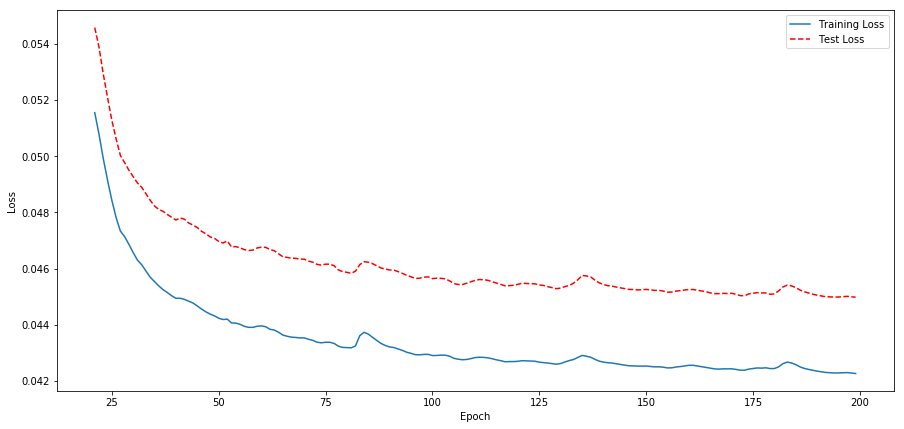

In [41]:
def baseline_model():
    model = Sequential()
    model.add(Dense(7, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
    return model

model = baseline_model()

def train(ep):
    model.fit(X_train,y_train,epochs=1,batch_size=50+ep, verbose=0)
    pred1=model.predict(X_train)
    pred2=model.predict(X_test)
    err1=mean_squared_error(pred1,y_train)
    err2=mean_squared_error(pred2,y_test)
    return err1,err2
plt_err1=[]
plt_err2=[]
epch=[]
for ep in range(1,200):
    err1,err2=train(ep)
    if ep > 20:
        plt_err1.append(err1)
        plt_err2.append(err2)
        epch.append(ep)
 
plt.plot(epch,plt_err1,label="Training Loss")
plt.plot(epch,plt_err2,'r--',label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#0.047

3
4
5
6
7
8
9
10
11
12
13
14
15
16


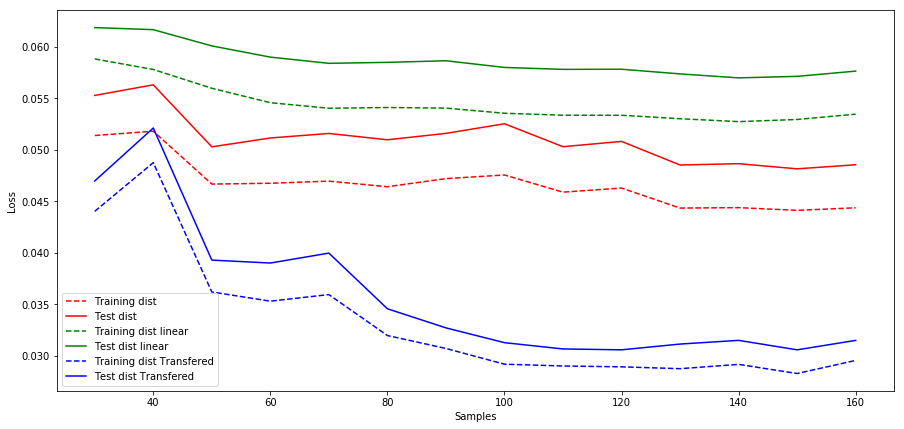

In [42]:

def baseline_model(activation='sigmoid'):
    model = Sequential()
    model.add(Dense(8, input_dim=3, kernel_initializer='normal', activation=activation))
    model.add(Dense(3, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
    return model

from sklearn.linear_model import LinearRegression

plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]
numsamples=[]


for numsample in range(3, 17):
    print(numsample)
    modelTransferred = keras.models.load_model('sim_model.h5')
    model_linear = LinearRegression()
    
    modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
    pred1=modelNew.predict(X_train)
    pred2=modelNew.predict(X_test)
    err1=mean_squared_error(pred1,y_train)
    err2=mean_squared_error(pred2,y_test)
    
    modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
    pred1=modelTransferred.predict(X_train)
    pred2=modelTransferred.predict(X_test)
    err3=mean_squared_error(pred1,y_train)
    err4=mean_squared_error(pred2,y_test)
    
    model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
    pred1=model_linear.predict(X_train)
    pred2=model_linear.predict(X_test)
    err5=mean_squared_error(pred1,y_train)
    err6=mean_squared_error(pred2,y_test)
    
    plt_err1.append(err1)
    plt_err2.append(err2)
    
    plt_err1_transferred.append(err3)
    plt_err2_transferred.append(err4)
    
    plt_err1_linear.append(err5)
    plt_err2_linear.append(err6)
    
    numsamples.append(numsample*10)
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()
